# Experimenting with Data Collection and Collaborative Filtering for Nintendo Recommender System

In [1]:
#importing necessary libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [ ]:
#URL link for user Link3710
url = "https://www.nintendolife.com/users/link3710/games"
r = requests.get(url)

In [ ]:
#formatting as soup
html_text = r.text

soup = BeautifulSoup(html_text, "html.parser")

In [ ]:
#Checking out the head
print(soup.prettify)

In [ ]:
#Checking out the title
print(soup.title)

In [ ]:
#Checking out body
print(soup.body)

In [ ]:
games = soup.findAll("p")

In [ ]:
len(games)

In [ ]:
for i in range(len(games)):
    print(games[i])
    print('\n')

It looks like I need to find every p where class = "heading" or class = "description" - how can I do that?

In [ ]:
games[10]

In [ ]:
type(games[10])

In [ ]:
games[10].name

In [ ]:
games[10].attrs

In [ ]:
soup.a

In [ ]:
soup.findAll("a")

Seems like all of the game titles are in the a class and the game descriptions are in the p class

In [ ]:
game_titles = soup.findAll("a")

In [ ]:
game_titles[42].attrs

In [ ]:
spans = soup.findAll("span")

In [ ]:
spans

In [ ]:
spans[94].contents[0]

In [ ]:
spans[96].contents[0]

In [ ]:
spans[94]

In [ ]:
spans[94].attrs

In [ ]:
if spans[94]["class"] == ['title', 'accent-hover']:
    print(True)

In [ ]:
spans[95]

In [ ]:
spans[95].attrs

In [ ]:
if spans[95]["class"] == ["subtitle"]: 
    print(True)
else:
    print(False)

In [ ]:
spans[96]

In [ ]:
spans[96].attrs

In [ ]:
spans[94].contents

In [ ]:
spans[96].contents

In [ ]:
#I'm going to set up a dataframe with 3 columns - user, game and rating

cols = ["User", "Game", "Rating"]

df = pd.DataFrame(columns = cols)

In [ ]:
len(spans)

In [ ]:
games = []
ratings = []

for i in range(len(spans)):
    try:
        if spans[i]["class"] == ["title", "accent-hover"]:
            games.append(spans[i].contents[0])
            if spans[i+2]["class"] == ["value"]:
                ratings.append(spans[i+2].contents[0])
            else:
                ratings.append("No Score")
    except KeyError:
        pass
    
if len(games) > len(ratings):
    ratings.append("No Score")

In [ ]:
print(games)
print(ratings)

In [ ]:
df["Game"] = games
df["Rating"] = ratings

In [ ]:
df["User"] = "link3710"

In [ ]:
df.head(10)

Next Steps: Figure out pagination, figure out how to pull multiple users

The pagination element of the page is tagged in the following manner: <br>
"< nav class ="ui-listing-pagination" > <br>
There are then child tags equal to the number of pages that a given user has, with the last page tagged as follows: <br>
< li class = "last" > <br>
Within that last class is contained a class that looks like this: <br>
< a class="accent accent-bg-hover accent-border" href="/users/link3710/games?sort=date&amp;status=own&amp;style=tile&amp;page=4" title="Goto Page 4">4</ a>
<br>
I need to get the contents of that last tag out.


In [ ]:
#last tag
my_page_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"})

In [ ]:
my_page_tags

In [ ]:
page_tags = []
for tag in my_page_tags:
    page_tags.append(int(tag.contents[0]))
    
print(page_tags)

In [ ]:
max_page_tags = max(page_tags)

In [ ]:
max_page_tags = int(max_page_tags)

In [ ]:
max_page_tags

In [ ]:
max_page_tags * 2

In order to get the data for multiple users, I'll have to have the usernames stored in another object prior to requesting my pages, so for now, I'm not going to worry about programmatically retrieving the username from a given user's page.

In [2]:
#Creating Function for getting max pages

def get_max_pages(user_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our user
    url = "https://www.nintendolife.com/users/" + user_name + "/games"
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a user only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [ ]:
print(get_max_pages("link3710"))

In [3]:
#Creating Function for getting games and ratings into dataframe=
def games_ratings_to_df(user_name, max_pages):
    '''Function for putting a user's games
    and ratings into a dataframe'''
    
    #Setting up object holders
    cols = ["User", "Game", "Rating"]
    df = pd.DataFrame(columns=cols)
    games = []
    ratings = []
    
    #iterating through pages
    for page in range(1, max_pages+1):
        #Url is different if on first page rather than other pages
        if page == 1:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games"
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
        #Adding the rest of the url pages       
        else:
            #Setting parameters and getting first soup for our user
            url = "https://www.nintendolife.com/users/" + user_name + "/games?page=" + str(page)
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting our game tags
            spans = soup.findAll("span")
            for i in range(len(spans)):
                #Try-except block for key-errors when filtering for class
                try:
                    #conditional for just tag types that are holding game titles
                    if spans[i]["class"] == ["title", "accent-hover"]:
                        games.append(spans[i].contents[0])
                        #Conditional for putting rating or no score - can explain how
                        if spans[i+2]["class"] == ["value"]:
                            ratings.append(spans[i+2].contents[0])
                        else:
                            ratings.append("No Score")
                except KeyError:
                    pass
            #appending no score for last game (if last game had no score)
            if len(games) > len(ratings):
                ratings.append("No Score")
    
    #Adding our games and ratings list to dataframe
    df["Game"] = games
    df["Rating"] = ratings
    df["User"] = user_name
    
    return df

In [4]:
link3710_ratings = games_ratings_to_df("link3710", 4)
print(link3710_ratings.head(10))
print(link3710_ratings.shape)

       User                        Game    Rating
0  link3710            Daemon X Machina  No Score
1  link3710     Spyro Reignited Trilogy         9
2  link3710                 Gato Roboto         8
3  link3710         DELTARUNE Chapter 1         9
4  link3710  Super Smash Bros. Ultimate        10
5  link3710      Katamari Damacy REROLL         9
6  link3710         Horizon Chase Turbo         8
7  link3710        Dragon Ball FighterZ         8
8  link3710                   Undertale         9
9  link3710                    Okami HD         9
(189, 3)


In [5]:
link3710_pages = get_max_pages("link3710")
link3710_ratings = games_ratings_to_df("link3710", link3710_pages)

In [6]:
link3710_ratings.head(10)

,User,Game,Rating
0,link3710,Daemon X Machina,No Score
1,link3710,Spyro Reignited Trilogy,9
2,link3710,Gato Roboto,8
3,link3710,DELTARUNE Chapter 1,9
4,link3710,Super Smash Bros. Ultimate,10
5,link3710,Katamari Damacy REROLL,9
6,link3710,Horizon Chase Turbo,8
7,link3710,Dragon Ball FighterZ,8
8,link3710,Undertale,9
9,link3710,Okami HD,9


In [7]:
link3710_ratings.tail(10)

,User,Game,Rating
179,link3710,Donkey Kong,10
180,link3710,The Legend of Zelda: Link's Awakening,10
181,link3710,Kirby's Dream Land,7
182,link3710,Final Fantasy Adventure,7
183,link3710,Final Fantasy Legend II,8
184,link3710,The Hunt for Red October,9
185,link3710,Dr. Mario,8
186,link3710,Gargoyle's Quest,7
187,link3710,QIX,8
188,link3710,Pinball: Revenge of the 'Gator,9


### Function for Pulling Users

My first idea for pulling users would be to iterate through a long-running thread from the NintendoLife forums and pull out the user names, and then dedupe them. 

The page URLs for the forum posts go by multiples of 20 - one page can only have a max of 20 posts. 
I could go to the last page of the thread, subtract by 1 (because of the page sequencing), and multiply by 20 to get the #start parameter of the URL Thread.

But, to start, I need to be able to get the max number of pages from a thread programatically. I'm going to try to reproduce my get_max_pages function from the user page and modify it for forum pages.

In [8]:
def get_max_pages_thread(user_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our user
    url = "https://www.nintendolife.com/users/" + user_name + "/games"
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a user only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent accent-bg-hover accent-border"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [ ]:
#Setting parameters and getting soup for our thread

thread_name = "what_do_you_think_the_nx_is_poll"
url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

In [ ]:
page_tags = soup.findAll("a", {"class": "accent-border accent-bg-hover accent"})

In [ ]:
page_tags

In [12]:
def get_max_pages_thread(thread_name):
    '''Function for getting the maximum number of pages of games
       from our user page'''
    
    #Setting parameters and getting soup for our thread
    url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
    r = requests.get(url) 
    html_text = r.text
    soup = BeautifulSoup(html_text, "html.parser")

    #try-except block for if a thread only has one page
    try:
        pagination_tags = soup.findAll("a", {"class": "accent-border accent-bg-hover accent"}) #just pagination tags
        page_tag_numbers = []
        for tag in pagination_tags:
            page_tag_numbers.append(int(tag.contents[0]))
        max_page_tag = max(page_tag_numbers)
        return max_page_tag
    
    except:
        max_page_tag = 1
        return max_page_tag

In [ ]:
max_pages_thread = get_max_pages_thread("what_do_you_think_the_nx_is_poll")
print(max_pages_thread)

In [ ]:
for i in range(max_pages_thread):
    print(i*20)

Lucikly, the url query sequencing within the thread has the same bounds as python printing - what I mean by that is, the iteration value is 0 when starting at the first page, and then increases in 20s - the same bounds as the thread start= query value. <br> 
<br>
Now, I need to find how to pull out all of the user names from the forum pages.

In [ ]:
#Setting parameters and getting soup for our thread

thread_name = "what_do_you_think_the_nx_is_poll"
url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

In [ ]:
user_names = soup.findAll("a", {"class": "accent username"})

In [ ]:
for user in user_names:
    print(user.contents[0])

In [ ]:
max_pages_thread

In [ ]:
thread_name = "what_do_you_think_the_nx_is_poll"
url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
r = requests.get(url) 
html_text = r.text
soup = BeautifulSoup(html_text, "html.parser")

for i in range(max_pages_thread):
    n_posts = i * 20
    if n_posts == 0:
        print(url)
    else:
        print(url + "?start=" + str(n_posts))

In [15]:
#Now lets try to collect for multiple users

def get_users(thread_name, max_pages):
    '''Function for collecting all users from a thread. 
    Params: thread name (string), max number of pages
    returns :De-duplicated list of users'''
    
    users = []
    for i in range(max_pages):
        n_posts = i * 20
        if n_posts == 0:            
            #Setting parameters 
            url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting user tags
            user_names = soup.findAll("a", {"class": "accent username"})
            for user in user_names:
                users.append(user.contents[0])

        else:           
            #Setting parameters 
            url = "https://www.nintendolife.com/forums/nintendo-switch/" + thread_name + "?start=" + str(n_posts)
            r = requests.get(url) 
            html_text = r.text
            soup = BeautifulSoup(html_text, "html.parser")
            
            #Getting user tags
            user_names = soup.findAll("a", {"class": "accent username"})
            for user in user_names:
                users.append(user.contents[0])
                
    #Deduplicating List
    deduped_users = list(set(users))
    return deduped_users

In [16]:
thread_pages = get_max_pages_thread("the_switch_eshop_recommendations")
thread_users = get_users("the_switch_eshop_recommendations", thread_pages)

In [19]:
df = pd.DataFrame()
for user in thread_users:
    max_pages = get_max_pages(user)
    user_games_ratings = games_ratings_to_df(user, max_pages)
    df = df.append(user_games_ratings)

In [20]:
df.head()

,User,Game,Rating
0,New_Guest,Donkey Kong Land,9
1,New_Guest,Wario Land: Super Mario Land 3,10
2,New_Guest,The Legend of Zelda: Link's Awakening,10
3,New_Guest,Super Mario Land 2: 6 Golden Coins,10
4,New_Guest,Teenage Mutant Ninja Turtles II: Back from the...,10


In [21]:
df.tail()

,User,Game,Rating
7,Snadertjuh,Super Mario Galaxy,No Score
8,Snadertjuh,Paper Mario: The Thousand-Year Door,No Score
9,Snadertjuh,The Legend of Zelda: The Wind Waker,No Score
10,Snadertjuh,Super Smash Bros. Melee,No Score
11,Snadertjuh,Banjo-Kazooie,No Score


In [22]:
df["User"].nunique()

170

In [23]:
df["Game"].value_counts()

The Legend of Zelda: Breath of the Wild       123
Super Mario Odyssey                            87
Mario Kart 8 Deluxe                            78
Splatoon 2                                     59
The Legend of Zelda: Link's Awakening          56
Mario + Rabbids Kingdom Battle                 51
Super Smash Bros. Ultimate                     48
Donkey Kong Country: Tropical Freeze           48
Super Mario 3D World                           44
Bayonetta 2                                    43
Mario Kart 8                                   41
The Legend of Zelda: Ocarina of Time 3D        41
Super Mario Maker                              40
Super Mario Galaxy 2                           39
Super Smash Bros. for Wii U                    38
Splatoon                                       37
The Legend of Zelda: A Link Between Worlds     36
Bayonetta                                      35
The Legend of Zelda: Twilight Princess         34
Super Mario 3D Land                            34


In [24]:
df.shape

(10140, 3)

In [25]:
df["Rating"].value_counts()

No Score    3295
8           1863
9           1821
7           1208
10          1197
6            424
5            153
4             67
1             41
3             37
2             34
Name: Rating, dtype: int64

In [26]:
rated_df = df[df["Rating"] != "No Score"]

In [27]:
rated_df["Rating"].value_counts()

8     1863
9     1821
7     1208
10    1197
6      424
5      153
4       67
1       41
3       37
2       34
Name: Rating, dtype: int64

In [28]:
rated_df.shape

(6845, 3)

In [29]:
rated_df.groupby("Rating").count()

,User,Game
Rating,,
1,41,41
10,1197,1197
2,34,34
3,37,37
4,67,67
5,153,153
6,424,424
7,1208,1208
8,1863,1863


In [31]:
# Importing the data into surprise for start with our algorithm
from surprise import Reader, Dataset, accuracy

reader = Reader(rating_scale=(1, 10))
game_data = Dataset.load_from_df(rated_df[['User', 'Game', 'Rating']], reader)

In [33]:
game_data.raw_ratings

[('New_Guest', 'Donkey Kong Land', 9.0, None),
 ('New_Guest', 'Wario Land: Super Mario Land 3', 10.0, None),
 ('New_Guest', "The Legend of Zelda: Link's Awakening", 10.0, None),
 ('New_Guest', 'Super Mario Land 2: 6 Golden Coins', 10.0, None),
 ('New_Guest',
  'Teenage Mutant Ninja Turtles II: Back from the Sewers',
  10.0,
  None),
 ('New_Guest', 'Nintendo World Cup', 8.0, None),
 ('New_Guest',
  'Teenage Mutant Ninja Turtles: Fall of the Foot Clan',
  10.0,
  None),
 ('New_Guest', 'Super Mario Land', 10.0, None),
 ('New_Guest', 'Tetris', 10.0, None),
 ('Magician', "Dragon's Dogma: Dark Arisen", 9.0, None),
 ('Magician', 'Our World is Ended', 4.0, None),
 ('Magician', 'RICO', 8.0, None),
 ('Magician', 'The Caligula Effect: Overdose', 6.0, None),
 ('Magician', 'Rad Rodgers Radical \ufeffEdition', 7.0, None),
 ('Magician', 'RemiLore', 7.0, None),
 ('Magician', 'Reverie: Sweet As Edition', 8.0, None),
 ('Magician', 'RIOT - Civil Unrest', 4.0, None),
 ('Magician', 'Sphinx and the Cursed M

In [34]:
game_df = pd.DataFrame(game_data.raw_ratings, columns=['User', 'Item', 'Rating', 'Unused'])
game_df.groupby("Rating").count()

,User,Item,Unused
Rating,,,
1.0,41,41,0
2.0,34,34,0
3.0,37,37,0
4.0,67,67,0
5.0,153,153,0
6.0,424,424,0
7.0,1208,1208,0
8.0,1863,1863,0
9.0,1821,1821,0


In [37]:
#80-20 split for train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(game_data, test_size=.2)

In [38]:
print("Number of users: ", trainset.n_users)
print("Number of items: ", trainset.n_items)
print("Density: ", (trainset.n_ratings/(trainset.n_users * trainset.n_items)))

Number of users:  139
Number of items:  1908
Density:  0.020647632837126527


In [39]:
trainset.n_ratings

5476

In [45]:
game_df.head()

,User,Item,Rating,Unused
0,New_Guest,Donkey Kong Land,9.0,None
1,New_Guest,Wario Land: Super Mario Land 3,10.0,None
2,New_Guest,The Legend of Zelda: Link's Awakening,10.0,None
3,New_Guest,Super Mario Land 2: 6 Golden Coins,10.0,None
4,New_Guest,Teenage Mutant Ninja Turtles II: Back from the...,10.0,None


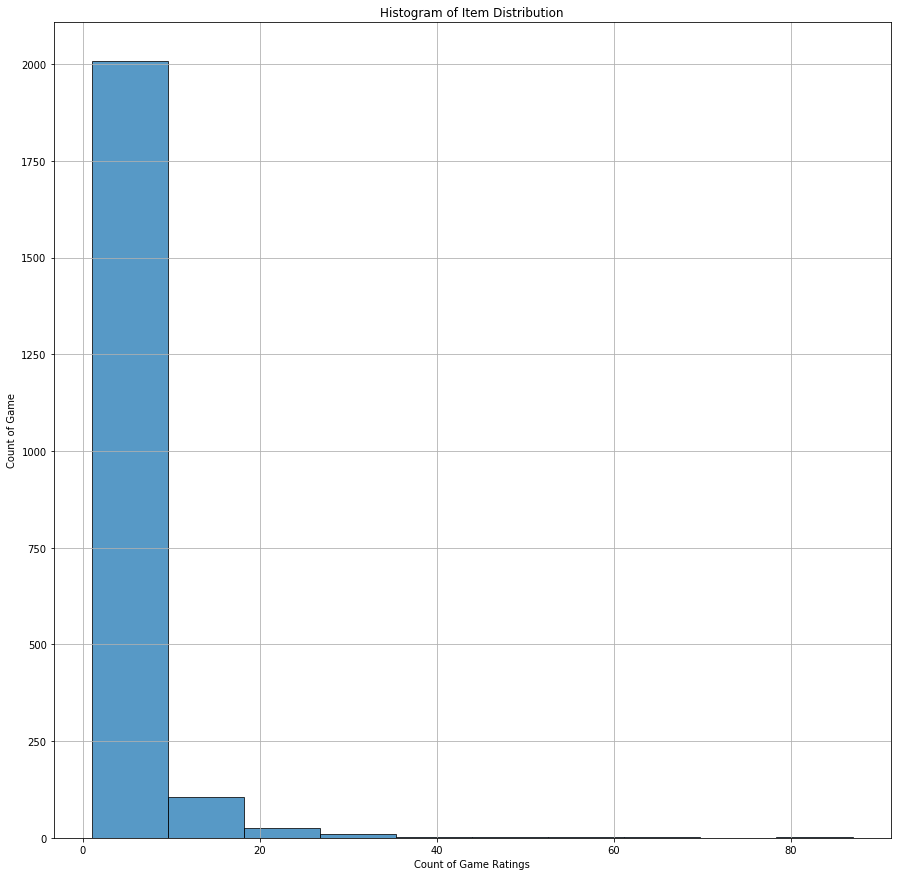

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.xlabel('Count of Game Ratings')
plt.ylabel('Count of Game')
plt.title('Histogram of Item Distribution')
plt.grid(True)
#log=True, bins=30,
plt.hist(game_df.groupby("Item")["Rating"].count(), bins=10, alpha=0.75, edgecolor='black')
plt.show()

Lots of games that were only rated a 1-10 times, a lot fewer games that were rated 40+ times

(array([68., 20., 18.,  8., 10.,  4.,  2.,  1.,  1.,  3.,  1.,  1.,  2.,
         0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  1.        ,  19.06666667,  37.13333333,  55.2       ,
         73.26666667,  91.33333333, 109.4       , 127.46666667,
        145.53333333, 163.6       , 181.66666667, 199.73333333,
        217.8       , 235.86666667, 253.93333333, 272.        ,
        290.06666667, 308.13333333, 326.2       , 344.26666667,
        362.33333333, 380.4       , 398.46666667, 416.53333333,
        434.6       , 452.66666667, 470.73333333, 488.8       ,
        506.86666667, 524.93333333, 543.        ]),
 <a list of 30 Patch objects>)

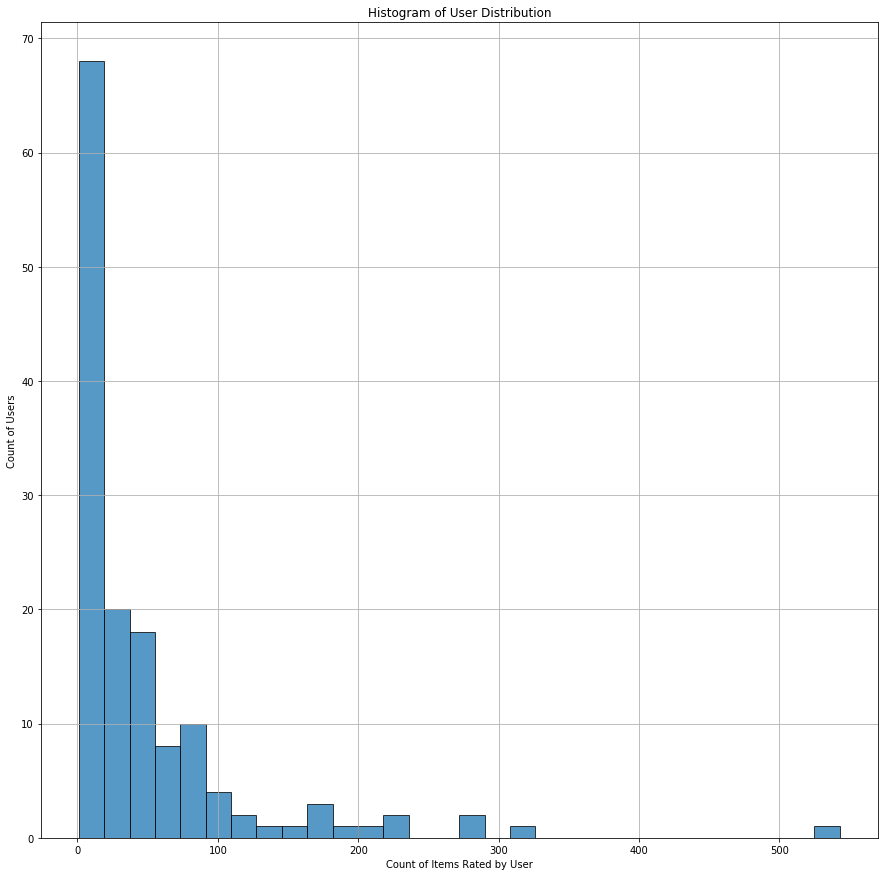

In [53]:
plt.figure(figsize=(15,15))
plt.xlabel('Count of Items Rated by User')
plt.ylabel('Count of Users')
plt.title('Histogram of User Distribution')
plt.grid(True)
plt.hist(game_df.groupby("User")["Rating"].count(), alpha=0.75, bins=30, edgecolor='black')

Most users only rated a few games, but a handful of users rated 80-100 games.

(array([  41.,   34.,   37.,   67.,  153.,  424., 1208., 1863., 1821.,
        1197.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

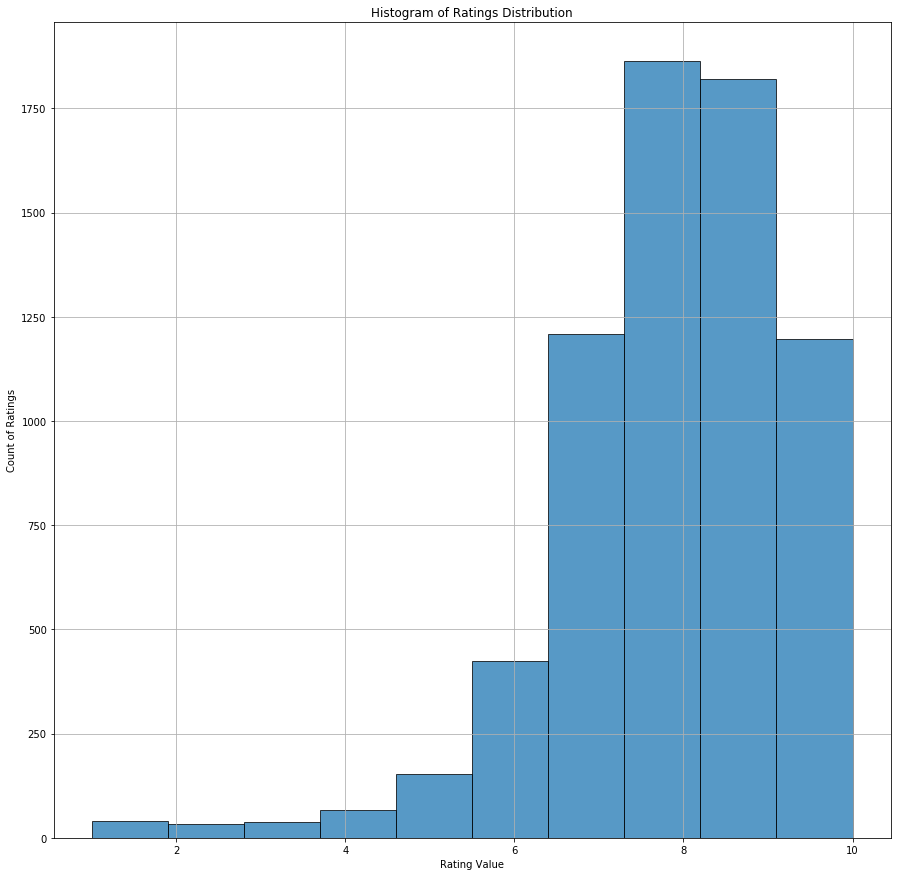

In [54]:
plt.figure(figsize=(15,15))
plt.xlabel('Rating Value')
plt.ylabel('Count of Ratings')
plt.title('Histogram of Ratings Distribution')
plt.grid(True)
plt.hist(game_df["Rating"], alpha=0.75, bins=10, edgecolor='black')

In [58]:
#Setting up naive user-based recommender
#Creating Similarity options and setting the methodology
from surprise.prediction_algorithms import KNNWithMeans
from surprise.model_selection import cross_validate, KFold
from surprise import accuracy
import numpy as np
sim_options_userbased = {'name': 'pearson',
                        'user_based': True}

user_based_cf = KNNWithMeans(sim_options=sim_options_userbased)

#Setting cross validation settings with a fixed random state of 1
kf = KFold(n_splits=5, random_state=np.random.seed(33))

userbased_results = []
for trainset, testset in kf.split(game_data):
    
    #Train and Test for Userbased
    user_based_cf.fit(trainset)
    predictions = user_based_cf.test(testset)
    
    # Compute, print and append RMSE to results list
    userbased_results.append(accuracy.rmse(predictions))

print("RMSE Results for 5 Folds for User Based Cross Validation: \n",userbased_results)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5441
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5682
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4433
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4857
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4970
RMSE Results for 5 Folds for User Based Cross Validation: 
 [1.5441432843245109, 1.568160245502547, 1.443301503769711, 1.4857457389632365, 1.4969835468904684]


In [60]:
#Comparing RMSEs with item-based
sim_options_itembased = {'name': 'pearson',
                        'user_based': True}

item_based_cf = KNNWithMeans(sim_options=sim_options_itembased)

#Setting cross validation settings with a fixed random state of 1
kf = KFold(n_splits=5, random_state=np.random.seed(33))

itembased_results = []
for trainset, testset in kf.split(game_data):
    
    #Train and Test for Userbased
    item_based_cf.fit(trainset)
    predictions = item_based_cf.test(testset)
    
    # Compute, print and append RMSE to results list
    itembased_results.append(accuracy.rmse(predictions))

print("RMSE Results for 5 Folds for Item Based Cross Validation: \n",itembased_results)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5441
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5682
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4433
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4857
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4970
RMSE Results for 5 Folds for Item Based Cross Validation: 
 [1.5441432843245109, 1.568160245502547, 1.443301503769711, 1.4857457389632365, 1.4969835468904684]


In [59]:
#Getting top 10 recommendations for each user
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# building trainset and fitting to our user-based KNN algo
trainset = game_data.build_full_trainset()
algo = KNNWithMeans(sim_options=sim_options_userbased)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Computing the pearson similarity matrix...
Done computing similarity matrix.
New_Guest ['Super Smash Bros. Ultimate', 'Diablo III: Eternal Collection', 'Undertale', 'Xenoblade Chronicles 2: Torna - The Golden Country', 'Captain Toad: Treasure Tracker', 'Sushi Striker: The Way of Sushido', 'Donkey Kong Country: Tropical Freeze', 'Bayonetta 2', 'Xenoblade Chronicles 2', 'The Elder Scrolls V: Skyrim']
Magician ['Mario Kart Tour', 'Disgaea DS', 'Pokémon Mystery Dungeon: Blue Rescue Team', 'La-Mulana', 'Fortune Street', 'MotoHeroz', 'Hydroventure', 'Art Style: Penta Tentacles', 'Art Style: light trax', 'WarioWare: D.I.Y. Showcase']
Arbor ['Donkey Kong Land', 'Wario Land: Super Mario Land 3', 'Super Mario Land 2: 6 Golden Coins', 'Teenage Mutant Ninja Turtles II: Back from the Sewers', 'Nintendo World Cup', 'Teenage Mutant Ninja Turtles: Fall of the Foot Clan', 'Super Mario Land', 'Tetris', "Dragon's Dogma: Dark Arisen", 'Our World is Ended']
UrsaBear ['Super Mario Land 2: 6 Golden Coins', '

In [61]:
type(top_n)

collections.defaultdict

In [64]:
#Getting top 10 neighbors for each item
# First, train the algortihm to compute the similarities between items
trainset = game_data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)



Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [69]:
game_df[100:110]

,User,Item,Rating,Unused
100,Magician,Bayonetta 2,9.0,None
101,Magician,The Longest Five Minutes,6.0,None
102,Magician,Monster Energy Supercross - The Official Video...,4.0,None
103,Magician,Dragon Quest Builders,8.0,None
104,Magician,Mercenary Kings Reloaded,7.0,None
105,Magician,Lost Sphear,7.0,None
106,Magician,RXN -Raijin-,7.0,None
107,Magician,The End Is Nigh,8.0,None
108,Magician,Party Planet,6.0,None
109,Magician,Stern Pinball Arcade,7.0,None


In [70]:
trainset.to_inner_iid("Bayonetta 2")

100

In [71]:
trainset.to_inner_iid("Dragon Quest Builders")

103

In [72]:
game_df[125:135]

,User,Item,Rating,Unused
125,Magician,DOOM,9.0,None
126,Magician,"Snipperclips Plus: Cut it out, together!",9.0,None
127,Magician,Sonic Forces,6.0,None
128,Magician,Cartoon Network: Battle Crashers,4.0,None
129,Magician,Monopoly for Nintendo Switch,6.0,None
130,Magician,Monster Jam: Crush It!,3.0,None
131,Magician,Super Mario Odyssey,9.0,None
132,Magician,Nights of Azure 2: Bride of the New Moon,7.0,None
133,Magician,Poi: Explorer Edition,7.0,None
134,Magician,This Is The Police,7.0,None


In [74]:
trainset.to_inner_iid("Super Mario Odyssey")

131

In [75]:
trainset.to_raw_iid(131)

'Super Mario Odyssey'

In [80]:
#Getting top 10 neighbors for each item
# First, train the algortihm to compute the similarities between items
trainset = game_data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)

# Retrieve inner id of the movie Toy Story
super_mario_odyssey_inner_id = algo.trainset.to_inner_iid("Super Mario Odyssey")
super_mario_odyssey_raw_id = algo.trainset.to_raw_iid(super_mario_odyssey_inner_id)

# Retrieve inner ids of the nearest neighbors of Super Mario Odyssey.
super_mario_odyssey_neighbors = algo.get_neighbors(super_mario_odyssey_inner_id, k=10)

# Convert inner ids of the neighbors into names.
super_mario_odyssey_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in super_mario_odyssey_neighbors)

# print(super_mario_odyssey_neighbors)
# toy_story_neighbors = (rid_to_name[rid]
#                        for rid in toy_story_neighbors)

print('The 10 nearest neighbors of Super Mario Odyssey are:')
for game in super_mario_odyssey_neighbors:
    print(game)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
The 10 nearest neighbors of Super Mario Odyssey are:
The Legend of Zelda: Breath of the Wild
Mario Kart 8
Mario Kart 8 Deluxe
The Legend of Zelda: The Wind Waker HD
Super Mario 3D World
Super Smash Bros. Ultimate
The Legend of Zelda: Skyward Sword
Xenoblade Chronicles 2
Yoshi's Woolly World
Metroid: Samus Returns
